In [1]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
data = ares.analysis.GalaxyPopulation() #for lit values

In [3]:
# Independent variables
# redshifts = np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75])
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

# redshifts = np.array([4, 5, 6, 7, 8])

# [0.10165, 0.25, 0.35, 0.45, 0.575, 0.725, 0.9][1.65, 2.5, 3.5]
# Ms = np.logspace(7, 12, 60)
Ms = np.linspace(7, 12, 60)


# print(Ms)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('logbins', Ms)]
blob_f1 = ['StellarMassFunction']

In [4]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [5]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)

# print(base_pars)
# This is important!
# base_pars['pop_calib_lum'] = None

In [6]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]', 
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(-1, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, .9),   'pq_func_par0[2]')
ps.add_distribution(UniformDistribution(-3, -0.01),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[3]')

In [7]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
# logM_0 = 11.0 #(0.01)

mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


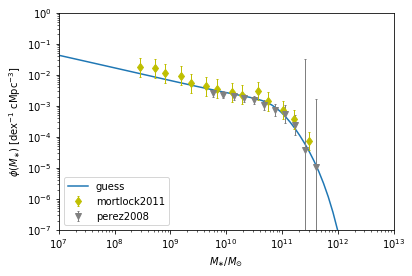

In [80]:
# base_pars
# Ms = np.logspace(7, 12, 60)

base_pars.update(guesses)
pop = ares.populations.GalaxyPopulation(**base_pars)

z = 1.35

smf = pop.StellarMassFunction(z, Ms)
pl.loglog(10**Ms, smf, label='guess')
data.PlotSMF(z=z, round_z=0.2)

pl.legend()
pl.show()

In [81]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

# print(fitter_smf.data)

In [82]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [83]:
# print(fitter.blob_names)
# print(fitter.blob_ivars)
# print(fitter.blob_funcs, fitter.blob_kwargs)


In [84]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 30

fitter.jitter = [0.2] * len(fitter.parameters)
# fitter.jitter = [0.01, 0.01, 0.001, 0.005, 0.01, 0.01, 0.04, 0.01]

fitter.guesses = guesses
# fitter.debug('True')
# fitter.pops
# nwalkers

# Fixing position of walker 1 (parameter pq_func_par0[1])
# Moved from -0.09999870420841492 to 0.270793992414609
# Fixing position of walker 3 (parameter pq_func_par0[1])
# Moved from -0.13470284485158318 to 0.17334027101544217
# Fixing position of walker 4 (parameter pq_func_par0[1])
# Moved from -0.2591712572550186 to 0.26012926594618974
# Fixing position of walker 8 (parameter pq_func_par0[1])
# Moved from -0.09736533572913358 to 0.270793992414609
# Fixing position of walker 9 (parameter pq_func_par0[1])
# Moved from -0.06854417351936147 to 0.03555631314680771
# Fixing position of walker 12 (parameter pq_func_par0[1])
# Moved from -0.06898853617200684 to 0.03241411814415928
# Fixing position of walker 13 (parameter pq_func_par0[1])
# Moved from -0.2059498123306483 to 0.4086639693194205
# Fixing position of walker 15 (parameter pq_func_par0[1])
# Moved from -0.025340819438499532 to 0.03555631314680771
# Fixing position of walker 16 (parameter pq_func_par0[1])
# Moved from -0.02292680

In [85]:
# Run the thing
fitter.run('MCMC_files/test_smfcal_3', burn=5, steps=45, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Thu Jul  2 12:39:10 2020
# Wrote MCMC_files/test_smfcal_3.burn.dd0000.facc.pkl: Thu Jul  2 12:40:47 2020
# Wrote MCMC_files/test_smfcal_3.burn.dd0001.facc.pkl: Thu Jul  2 12:41:31 2020
# Wrote MCMC_files/test_smfcal_3.burn.dd0002.facc.pkl: Thu Jul  2 12:42:11 2020
# Wrote MCMC_files/test_smfcal_3.burn.dd0003.facc.pkl: Thu Jul  2 12:42:58 2020
# Wrote MCMC_files/test_smfcal_3.burn.dd0004.facc.pkl: Thu Jul  2 12:43:33 2020
# Burn-in complete in 264 seconds.
# Fixing position of walker 1 (parameter pq_func_par0[1])
# Moved from -0.03964063145799096 to 0.3822583220712155
# Fixing position of walker 5 (parameter pq_func_par0[1])
# Moved from -0.0008946409943823008 to 0.17110576448743653
# Fixing position of walker 9 (parameter pq_func_par0[1])
# Moved from -0.06345661817432935 to 0.1820231754183106
# Fixing position of walker 12 (parameter pq_func_par0[1])
# Moved from -0.036013019967972515 to 0.1820231754183106
# Fixing posi

In [11]:
# anl = ares.analysis.ModelSet('MCMC_files/test_smfcal_3')
anl = ares.analysis.ModelSet('MCMC_files/smf_run2')

labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels
# anl.custom_labels


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : MCMC_files/                                                                            ####
#### prefix      : smf_run2                                                                               ####
#### N-d         : 8                                                                                      ####


# Loading MCMC_files/smf_run2.dd*.chain.pkl...
# Loaded MCMC_files/smf_run2.dd*.chain.pkl in 0.32 s.
# Loaded MCMC_files\smf_run2.dd0000.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0001.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0002.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0003.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0004.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0005.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0006.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0007.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0008.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0009.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0010.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0011.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0012.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0013.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\smf_run2.dd0014.blob_2d.galaxy_smf.pkl
# Loaded MCMC_

C:\Users\Emma\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


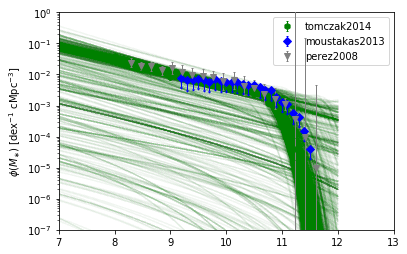

In [12]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.35
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='g', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.semilogy()

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [13]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 1.095035e+00
pq_func_par2[0]: -7.679495e-02
pq_func_par0[1]: 1.522250e-01
pq_func_par2[1]: -5.555606e-01
pq_func_par0[2]: 7.011982e-01
pq_func_par2[2]: -3.415715e-01
pq_func_par0[3]: 1.191317e+01
pq_func_par2[3]: 2.188574e-01


0 of 11000 chain elements ignored because of chain links with inf's/nan's.


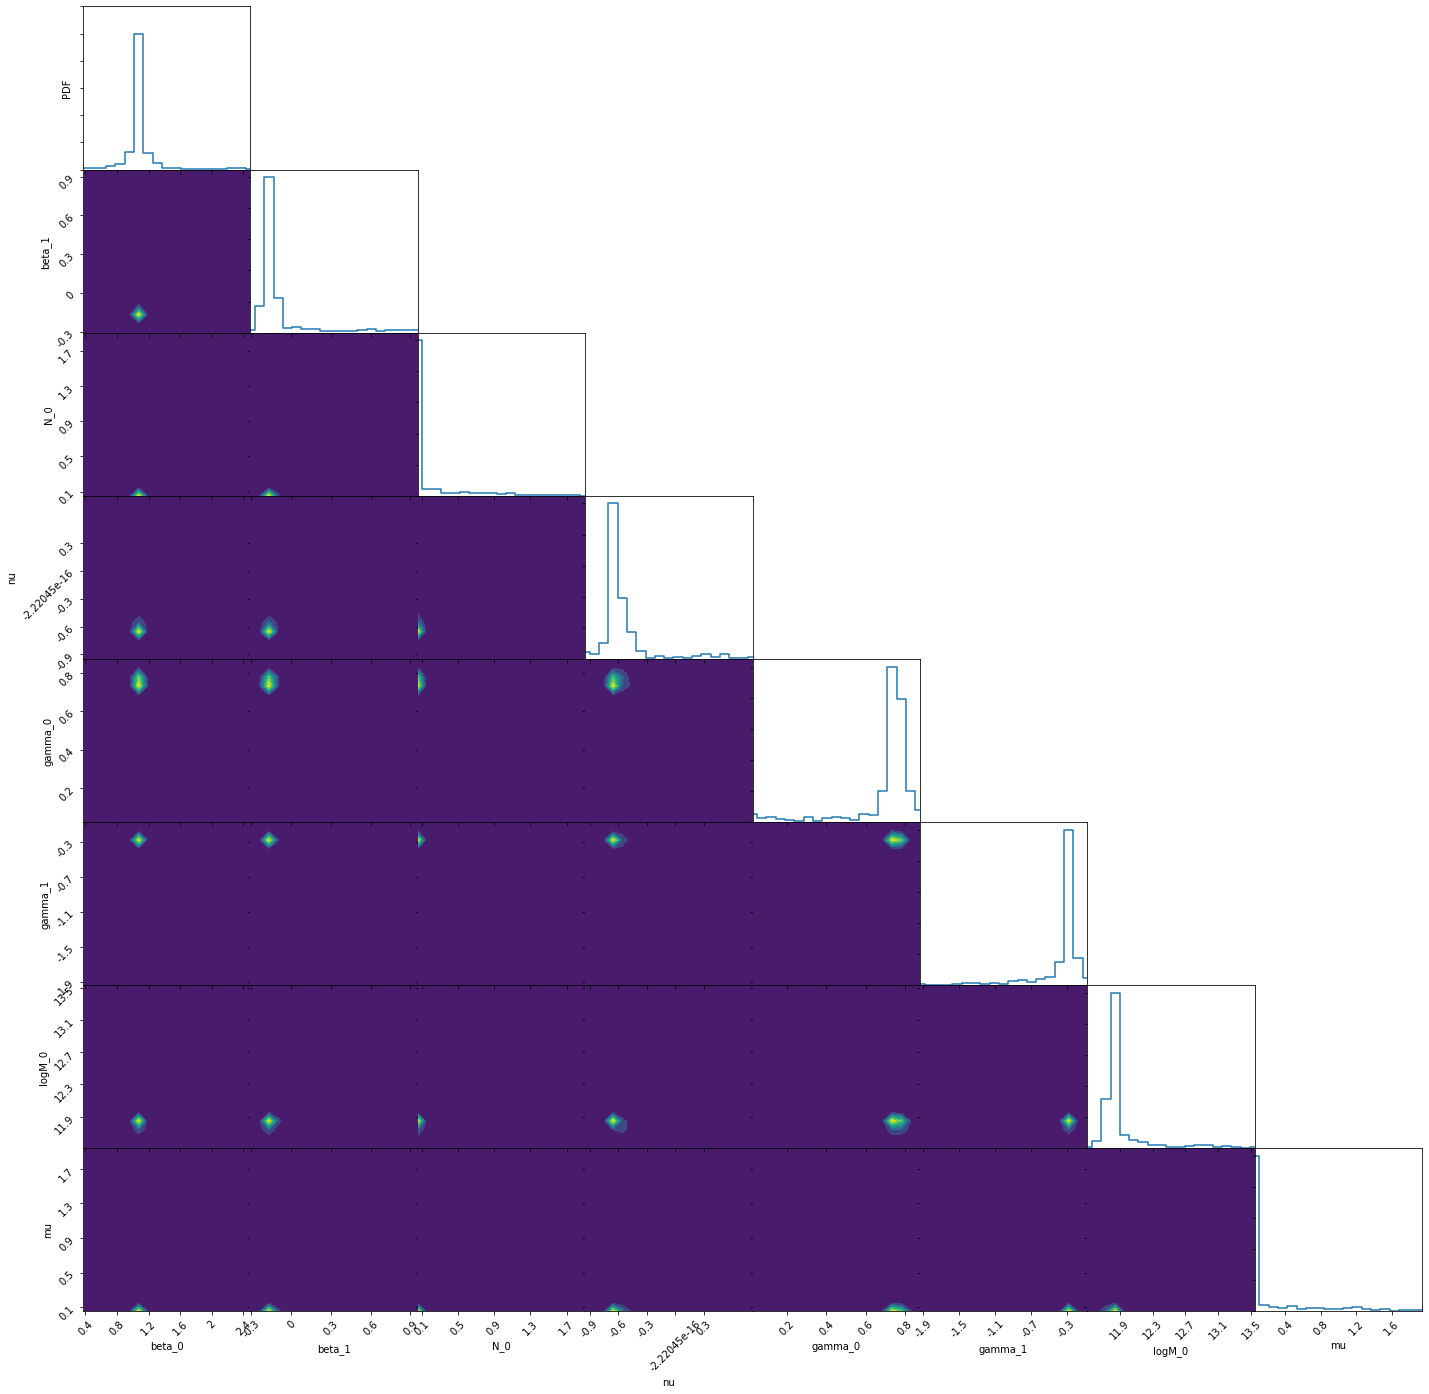

In [14]:

trig = anl.TrianglePlot(pars=params)

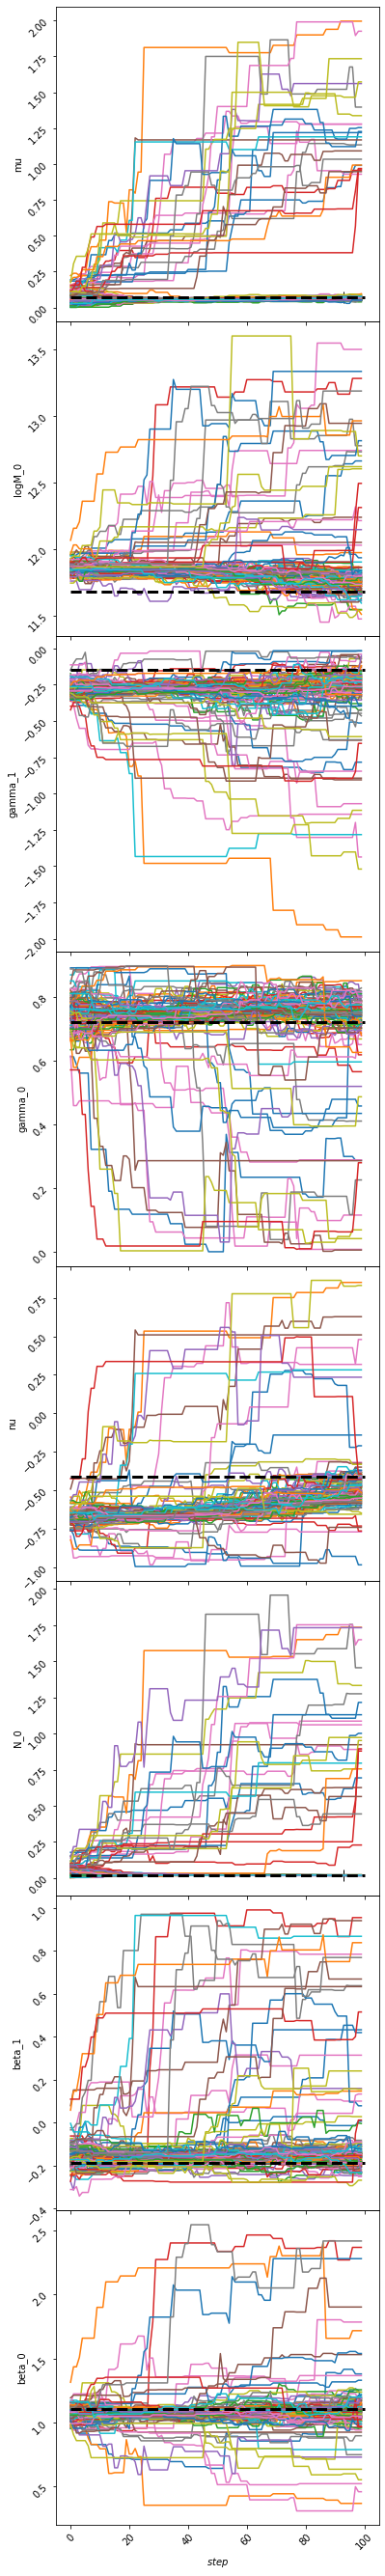

In [15]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [16]:
anl.max_likelihood_parameters()

{'pq_func_par0[0]': 1.1066192326767625,
 'pq_func_par2[0]': -0.1899521121347238,
 'pq_func_par0[1]': 0.01787547078485363,
 'pq_func_par2[1]': -0.40975713534364516,
 'pq_func_par0[2]': 0.7211695143658582,
 'pq_func_par2[2]': -0.14618450470328245,
 'pq_func_par0[3]': 11.683136817557259,
 'pq_func_par2[3]': 0.0715409485497524}

In [17]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.095035e+00
pq_func_par2[0]: -7.679495e-02
pq_func_par0[1]: 1.522250e-01
pq_func_par2[1]: -5.555606e-01
pq_func_par0[2]: 7.011982e-01
pq_func_par2[2]: -3.415715e-01
pq_func_par0[3]: 1.191317e+01
pq_func_par2[3]: 2.188574e-01


In [18]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [19]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(1.1066192326767625, array([0.02529237, 0.08761368]))
(-0.1899521121347238, array([0.12413458, 0.00078861]))
(0.01787547078485363, array([ 0.20343488, -0.00115324]))
(-0.40975713534364516, array([-0.07234064,  0.27163775]))
(0.7211695143658582, array([0.06625599, 0.03409471]))
(-0.14618450470328245, array([-0.08326318,  0.22967071]))
(11.683136817557259, array([ 0.26089513, -0.09075917]))
(0.0715409485497524, array([0.31832671, 0.02306494]))


In [20]:
pars_best = ares.util.ParameterBundle("emma:model1")
pars = ares.util.ParameterBundle("emma:model1")

# print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

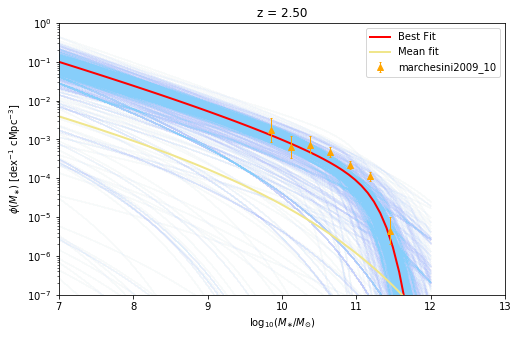

In [60]:
z = 2.5

# Ms_short = np.logspace(7, 13, 80)

# print(Ms)
fig, ax = pl.subplots(figsize=(8, 5))

ls_best = pop_best.StellarMassFunction(z, Ms)
ls_mean = pop_mean.StellarMassFunction(z, Ms)

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='lightskyblue', alpha=0.01, ax=ax)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, ax=ax, round_z=0.2, log10Mass=True)

ax.semilogy(Ms, ls_best, label='Best Fit', color="red", linewidth=2)
pl.semilogy(Ms, ls_mean, label='Mean fit', color="khaki", linewidth=2)

pl.title("z = %.2f" %z)
ax.set_xlabel('log$_{10}(M_{\\ast} / M_{\odot})$')
pl.legend()
# pl.ylim(1e-18, 1e2)
pl.show()

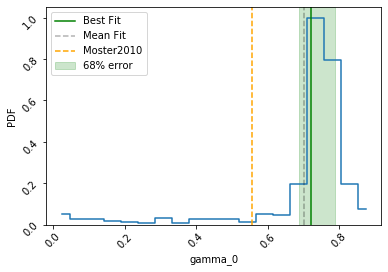

In [37]:
bests = [anl.get_1d_error(i, nu=0.68,  peak='mode') for i in params]

i = 4

ax = anl.PosteriorPDF(pars=params[i])

pl.axvline(x=bests[i][0], ls="-", color="green", label="Best Fit")

ax.axvspan(bests[i][0]-bests[i][1][1], bests[i][0]+bests[i][1][0], alpha=0.2, color='green' ,label="68% error")

pl.axvline(x=fit_mean[i], ls="--", color="black", label="Mean Fit", alpha=0.3)
pl.axvline(x=pars[params[i]], ls="--", color="orange", label="Moster2010")

pl.legend()
pl.show()